

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.


## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### INICIALIZACIÓN 

In [1]:
# Importar librerías incluidas en Python
import datetime
import os

# Importar librerías de terceros
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

<div class="alert alert-block alert-info">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Una buena práctica para cuando tengas que importar varias librerías es seguir el siguiente órden en las mismas:

- Primero todas las librerías que vienen ya con python cómo `datetime`, `os`, `json`, etc.
- Luego de las librerías de Python si las de terceros cómo `pandas`, `scipy`, `numpy`, etc.
- Por último, en el caso de que armes tu propio módulo en tu proyecto esto debería ir en tercer lugar, y recuerda siempre ordenar cada tipo por orden alfabético
    
Para cada sección se deben ordenar en orden alfabético
</div>

### CARGAR LOS DATOS

In [2]:
#Cargar el Dataset a analizar
#Reconocimiento de fechas y formación de nuevos índices. 
#Valores de index_col = la lista de números de columna o nombre de columna
#Valores de parse_date = La lista de número de columna o nombre de columna 

data_taxi = pd.read_csv('/datasets/taxi.csv', index_col= [0], parse_dates = [0])
print(f'\n Datos cargados correctamente. Con la siguiente dimensión:{data_taxi.shape}')


 Datos cargados correctamente. Con la siguiente dimensión:(26496, 1)


### ANÁLISIS DE LOS DATOS 

In [3]:
print("\nInformación general del DataFrame")
data_taxi.info()
print("\n Estadísitica descriptiva")
data_taxi.describe()


Información general del DataFrame
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

 Estadísitica descriptiva


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
#Obtención de las 10 primeras filas de las bases de datos 
data_taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
#Verificación de las fechas esten en orden cronológico 
data_taxi.index.is_monotonic_increasing

True

In [6]:
#Comprobación de valores ausentes 
print('\n Valores nulos:')
print(data_taxi.isna().sum())


 Valores nulos:
num_orders    0
dtype: int64


In [7]:
#Verificación de que no haya duplicado. 
print(f"\n Se encontró que hay {data_taxi.index.duplicated().sum()} datos duplicados en el DataFrame")


 Se encontró que hay 0 datos duplicados en el DataFrame


In [8]:
#Observar de la primera fecha tomada y la ulitma 
print(f"Fecha inicial: {data_taxi.index.min()}")
print(f"Fecha final: {data_taxi.index.max()}")

Fecha inicial: 2018-03-01 00:00:00
Fecha final: 2018-08-31 23:50:00


## REMUESTREO POR HORA

In [9]:
#Remuestreo por hora
#En donde se utilizara 1H, lo que siginifica  a una hora 
data_taxi = data_taxi.resample('1H').sum()

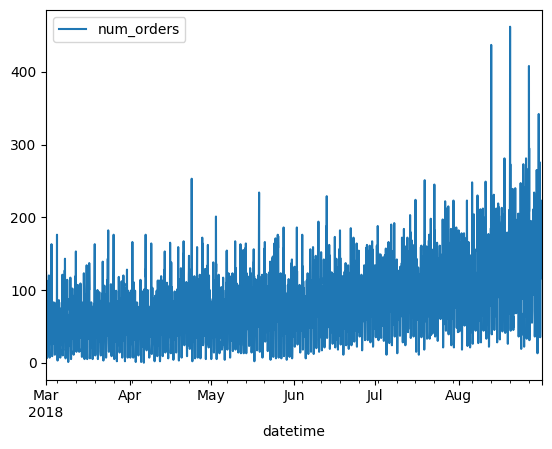

In [10]:
#Visualización de los datos 
data_taxi.plot()
plt.show()

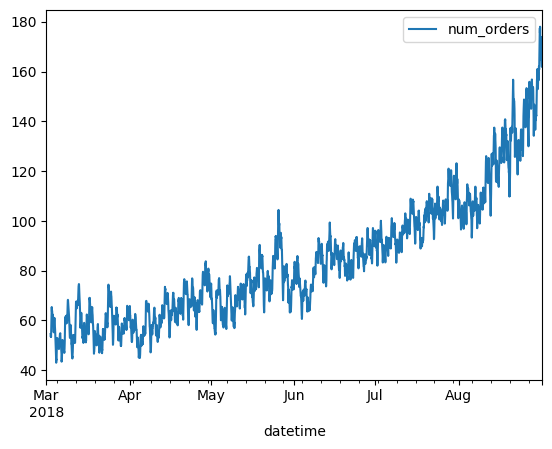

In [11]:
#Visualizaciín de la media movil 
'''
La media móviol, también conocida como promedio movil, es un método para suavizar
los datos en una serie temporal. 
El método consiste en encontrar los valores menos susceptibles a 
fluctuaciones, es decir, la media aritmética.
'''
data_taxi.rolling(40).mean().plot()
plt.show()

In [12]:
#Tendencias y estacionalidad
decomposed = seasonal_decompose(data_taxi)

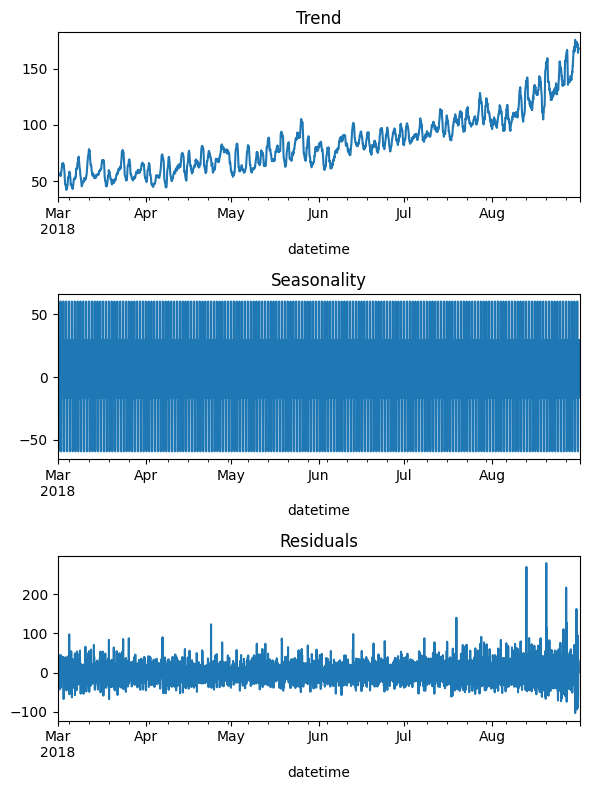

In [13]:
#Realización de los gradicos de la rendencia y estacionalidad 
plt.figure(figsize=(6,8))
plt.subplot(311)

# Para mostrar el gráfico de manera correcta, se especifico
# el eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca())
plt.title("Trend")
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title("Seasonality")
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title("Residuals")
plt.tight_layout()

En las gráficas que se obtuvieron se puede lograr apreciar lo siguiente: 
1. La tendencia (primer gráfico) es creciente desde marzo de 2018 hasta agosto del mismo año. En esta gráfica se puede sugerir que el aumento progresivo en el valor de la serie temporal.
2. En la estacionalidad (Segundo gráfico) nos revela patrones cíclicos que ocurren en intervalos regulares. Se puede observar que hay un patrón vertical y repetitivo que nos puede indicar que hay fluctuaciones diarias o semanales muy marcadas en los datos. 
3. En los residulas (tercer gráfico) se puede visualizar una varianza baja inicialmente, pero llegando a Agosto se observar pico más grnade- Dichos picos pueden representar anomalías o eventos inesperados. 

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy buen trabajo, realizaste las gráficas correctas para el análisis de datos temporales
</div>

## CREACIÓN DE CARACTERÍSTICAS 

In [14]:
def make_features(data_taxi, max_lag):
# Se separar en  año, día, mes y día de la semana en columnas diferentes
    data_taxi['year'] = data_taxi.index.year
    data_taxi['month'] = data_taxi.index.month
    data_taxi['day'] = data_taxi.index.day
    data_taxi['dayofweek'] = data_taxi.index.dayofweek
    
    #Caracteristicas de desfase 
    for lag in range(1, max_lag + 1):
        data_taxi['lag_{}'.format(lag)] = data_taxi['num_orders'].shift(lag)
    
    #Características de tendencia 
    data_taxi['trending'] =  seasonal_decompose(data_taxi['num_orders']).trend.shift(fill_value=0)
    
    #Caracterísiticas de estacionalidad 
    data_taxi['seasonal'] =  seasonal_decompose(data_taxi['num_orders']).seasonal.shift(fill_value=0)
        
    #Caracterisitcas de residuo 
    data_taxi['resid'] =  seasonal_decompose(data_taxi['num_orders']).resid.shift(fill_value=0)

In [15]:
#Agregar las nuevas caracteristicas que se hicieron en el df
#Se considerara 50 desfases 
make_features(data_taxi, 50)

In [16]:
#Verificar los cambios 
data_taxi.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,trending,seasonal,resid
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.0
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.248112,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.177074,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.982743,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.885407,NaN


## CONJUNTO DE ENTRENAMIENTO Y PRUEBA

In [17]:
#Dividir el dataframe en prueba y entrenamiento 
train, test = train_test_split(data_taxi, test_size = 0.1, shuffle = False)

#Eliminación de filas con valores ausentes 
train = train.dropna().copy()
test = test.dropna().copy()

#Comprobación del tamaño del tamaño de los conjuntos de entrenamiento y prueba
print(train.shape)
print(test.shape)

(3924, 58)
(431, 58)


In [18]:
#Dividir las caracterisitcas y el objetivo 
features_train = train.drop(['num_orders'], axis=1) 
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1) 
target_test = test['num_orders']

## ENTRENAMIENTO DE LOS MODELOS

### REGRESIÓN LINEAL 

In [19]:
#Entrenar el modelo de regresión lineal 
model = LinearRegression()
model.fit(features_train,target_train) 

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

eam_train = np.sqrt(mse(target_train, pred_train))
eam_test = np.sqrt(mse(target_test, pred_test ))

print(f"\n RECM para el conjunto de entrenamiento es: {eam_train} ")
print(f"\n RECM para el conjunto de preuba es: {eam_test} ")


 RECM para el conjunto de entrenamiento es: 21.696392028400663 

 RECM para el conjunto de preuba es: 39.517672441906605 


### MODELO DE  BOSQUE ALEATORIO

In [20]:
%%time
#Entrenamiento de un model de bosque aleatorio 
model_rf= RandomForestRegressor(random_state = 54321)

#Configuración de hiperparametros 
param_grid = {
    'n_estimators': [100],  # Número de árboles en el bosque
    'max_depth' : [10], # Profundidad máxima de los árboles
    'min_samples_split' : [2],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf' : [4],  # Número mínimo de muestras en una hoja
    'max_features' : ['auto', 'sqrt'] # Número de características consideradas para cada división
}

#Configuración de la busqueda de hiperparametros 
grid_search = GridSearchCV(estimator = model_rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose= 2
                          )
#Ajuste del conjunto de entrenamiento 
grid_search.fit(features_train, target_train )

#Imprimir los mejores hiperparametros 
print(f"\n Mejores hiperparametros: {grid_search.best_params_}")

#Predecir del conjunto de prueba 
pred_grid = grid_search.predict(features_test)

#Calcular el RECM 
recm_rf = np.sqrt(mse(target_test, pred_grid))

#Imprimir el resultado obtenido 
print(f"\n RECM para el conjunto de prueba: {recm_rf}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.6s

 Mejores hiperparametros: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

 RECM para el conjunto de prueba: 39.121651233656706
CPU times: user 19.9 s, sys: 5

### MODELO CATBOOST

In [21]:
%%time
#Entrenar un modelo CATBOOST
model_cb= CatBoostRegressor(random_state = 54321)

#Configuración de hiperparametros 
parameters = {
    'depth' : [6], # Profundidad del árbol
    'learning_rate': [0.1], #Tasa de aprendizaje
    'iterations' : [1000], #Número de árboles
    'rsm' : [1.0],  # Diferentes proporciones de característica
    'l2_leaf_reg' : [5]   # Regularización L2
}

#Configuración de la busqueda de hiperparametros 
grid_search_cb = GridSearchCV(estimator = model_cb, 
                           param_grid = parameters, 
                           cv = 3,
                           n_jobs = -1, 
                           scoring='neg_mean_squared_error',
                           verbose= 2
                          )
#Ajuste del conjunto de entrenamiento 
grid_search_cb.fit(features_train, target_train )

#Imprimir los mejores hiperparametros 
print(f"\n Mejores hiperparametros: {grid_search_cb.best_params_}")

#Predecir del conjunto de prueba 
pred_grid = grid_search_cb.predict(features_test)

#Calcular el RECM 
recm_cb = np.sqrt(mse(target_test, pred_grid))

#Imprimir el resultado obtenido 
print(f"\n RECM para el conjunto de prueba: {recm_cb}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 37.2469919	total: 58.6ms	remaining: 58.6s
1:	learn: 35.6540329	total: 66.7ms	remaining: 33.3s
2:	learn: 34.3735073	total: 74.3ms	remaining: 24.7s
3:	learn: 33.0669567	total: 82.1ms	remaining: 20.5s
4:	learn: 31.9172860	total: 90ms	remaining: 17.9s
5:	learn: 31.0175513	total: 97.8ms	remaining: 16.2s
6:	learn: 30.1392916	total: 105ms	remaining: 14.9s
7:	learn: 29.4933831	total: 113ms	remaining: 14s
8:	learn: 28.7959489	total: 121ms	remaining: 13.3s
9:	learn: 28.2320402	total: 129ms	remaining: 12.8s
10:	learn: 27.6211762	total: 137ms	remaining: 12.3s
11:	learn: 27.0696369	total: 144ms	remaining: 11.9s
12:	learn: 26.7525128	total: 152ms	remaining: 11.6s
13:	learn: 26.3456390	total: 160ms	remaining: 11.3s
14:	learn: 26.0502523	total: 168ms	remaining: 11s
15:	learn: 25.7124471	total: 176ms	remaining: 10.8s
16:	learn: 25.4348131	total: 183ms	remaining: 10.6s
17:	learn: 25.0831638	total: 191ms	remaining: 10.4s
18:	learn: 24.8

163:	learn: 16.6975505	total: 1.36s	remaining: 6.92s
164:	learn: 16.6600488	total: 1.36s	remaining: 6.91s
165:	learn: 16.6268056	total: 1.37s	remaining: 6.9s
166:	learn: 16.6197132	total: 1.38s	remaining: 6.88s
167:	learn: 16.6160935	total: 1.39s	remaining: 6.87s
168:	learn: 16.5643497	total: 1.4s	remaining: 6.86s
169:	learn: 16.5320395	total: 1.4s	remaining: 6.85s
170:	learn: 16.5006328	total: 1.41s	remaining: 6.84s
171:	learn: 16.4512810	total: 1.42s	remaining: 6.83s
172:	learn: 16.4466303	total: 1.43s	remaining: 6.82s
173:	learn: 16.4207377	total: 1.43s	remaining: 6.81s
174:	learn: 16.3888725	total: 1.44s	remaining: 6.8s
175:	learn: 16.3441093	total: 1.45s	remaining: 6.81s
176:	learn: 16.2991794	total: 1.46s	remaining: 6.8s
177:	learn: 16.2784755	total: 1.47s	remaining: 6.79s
178:	learn: 16.2473196	total: 1.48s	remaining: 6.77s
179:	learn: 16.1827417	total: 1.48s	remaining: 6.76s
180:	learn: 16.1265361	total: 1.49s	remaining: 6.75s
181:	learn: 16.0868530	total: 1.5s	remaining: 6.74s

339:	learn: 11.9993306	total: 2.79s	remaining: 5.41s
340:	learn: 11.9818742	total: 2.8s	remaining: 5.41s
341:	learn: 11.9473986	total: 2.81s	remaining: 5.41s
342:	learn: 11.9248446	total: 2.82s	remaining: 5.4s
343:	learn: 11.9089227	total: 2.83s	remaining: 5.39s
344:	learn: 11.8908699	total: 2.83s	remaining: 5.38s
345:	learn: 11.8499159	total: 2.85s	remaining: 5.38s
346:	learn: 11.8286312	total: 2.85s	remaining: 5.37s
347:	learn: 11.7995100	total: 2.86s	remaining: 5.36s
348:	learn: 11.7828601	total: 2.87s	remaining: 5.35s
349:	learn: 11.7714463	total: 2.88s	remaining: 5.34s
350:	learn: 11.7525920	total: 2.88s	remaining: 5.33s
351:	learn: 11.7403452	total: 2.89s	remaining: 5.32s
352:	learn: 11.7155696	total: 2.9s	remaining: 5.32s
353:	learn: 11.7130916	total: 2.91s	remaining: 5.31s
354:	learn: 11.6917728	total: 2.92s	remaining: 5.3s
355:	learn: 11.6863541	total: 2.92s	remaining: 5.29s
356:	learn: 11.6508430	total: 2.93s	remaining: 5.29s
357:	learn: 11.6301306	total: 2.94s	remaining: 5.2

513:	learn: 8.7919726	total: 4.2s	remaining: 3.97s
514:	learn: 8.7904232	total: 4.21s	remaining: 3.96s
515:	learn: 8.7781585	total: 4.22s	remaining: 3.96s
516:	learn: 8.7680088	total: 4.23s	remaining: 3.95s
517:	learn: 8.7540694	total: 4.24s	remaining: 3.94s
518:	learn: 8.7402012	total: 4.25s	remaining: 3.93s
519:	learn: 8.7174367	total: 4.25s	remaining: 3.92s
520:	learn: 8.7164516	total: 4.26s	remaining: 3.92s
521:	learn: 8.6960483	total: 4.27s	remaining: 3.91s
522:	learn: 8.6722379	total: 4.28s	remaining: 3.9s
523:	learn: 8.6579317	total: 4.28s	remaining: 3.89s
524:	learn: 8.6498909	total: 4.29s	remaining: 3.88s
525:	learn: 8.6423297	total: 4.3s	remaining: 3.87s
526:	learn: 8.6298918	total: 4.31s	remaining: 3.87s
527:	learn: 8.6185946	total: 4.31s	remaining: 3.86s
528:	learn: 8.5957776	total: 4.32s	remaining: 3.85s
529:	learn: 8.5892949	total: 4.33s	remaining: 3.84s
530:	learn: 8.5681522	total: 4.34s	remaining: 3.83s
531:	learn: 8.5648041	total: 4.34s	remaining: 3.82s
532:	learn: 8.5

692:	learn: 6.7165503	total: 5.62s	remaining: 2.49s
693:	learn: 6.7018096	total: 5.63s	remaining: 2.48s
694:	learn: 6.6860519	total: 5.64s	remaining: 2.47s
695:	learn: 6.6782049	total: 5.65s	remaining: 2.47s
696:	learn: 6.6579514	total: 5.65s	remaining: 2.46s
697:	learn: 6.6436641	total: 5.66s	remaining: 2.45s
698:	learn: 6.6304134	total: 5.67s	remaining: 2.44s
699:	learn: 6.6289029	total: 5.68s	remaining: 2.43s
700:	learn: 6.6121146	total: 5.68s	remaining: 2.42s
701:	learn: 6.5934075	total: 5.69s	remaining: 2.42s
702:	learn: 6.5777739	total: 5.7s	remaining: 2.41s
703:	learn: 6.5601643	total: 5.71s	remaining: 2.4s
704:	learn: 6.5485784	total: 5.72s	remaining: 2.39s
705:	learn: 6.5478888	total: 5.73s	remaining: 2.38s
706:	learn: 6.5341551	total: 5.73s	remaining: 2.38s
707:	learn: 6.5336521	total: 5.74s	remaining: 2.37s
708:	learn: 6.5142576	total: 5.75s	remaining: 2.36s
709:	learn: 6.5038453	total: 5.76s	remaining: 2.35s
710:	learn: 6.4853768	total: 5.77s	remaining: 2.34s
711:	learn: 6.

864:	learn: 5.1239684	total: 7.04s	remaining: 1.1s
865:	learn: 5.1146239	total: 7.05s	remaining: 1.09s
866:	learn: 5.1076640	total: 7.06s	remaining: 1.08s
867:	learn: 5.0951142	total: 7.07s	remaining: 1.07s
868:	learn: 5.0863500	total: 7.07s	remaining: 1.07s
869:	learn: 5.0849406	total: 7.08s	remaining: 1.06s
870:	learn: 5.0843706	total: 7.09s	remaining: 1.05s
871:	learn: 5.0721065	total: 7.1s	remaining: 1.04s
872:	learn: 5.0656945	total: 7.11s	remaining: 1.03s
873:	learn: 5.0584652	total: 7.12s	remaining: 1.03s
874:	learn: 5.0477406	total: 7.13s	remaining: 1.02s
875:	learn: 5.0432308	total: 7.14s	remaining: 1.01s
876:	learn: 5.0390666	total: 7.15s	remaining: 1s
877:	learn: 5.0300988	total: 7.15s	remaining: 994ms
878:	learn: 5.0226676	total: 7.16s	remaining: 986ms
879:	learn: 5.0115536	total: 7.17s	remaining: 978ms
880:	learn: 5.0029707	total: 7.18s	remaining: 970ms
881:	learn: 4.9942586	total: 7.18s	remaining: 961ms
882:	learn: 4.9822287	total: 7.19s	remaining: 953ms
883:	learn: 4.972

26:	learn: 22.8229602	total: 211ms	remaining: 7.6s
27:	learn: 22.7194142	total: 219ms	remaining: 7.6s
28:	learn: 22.6022212	total: 227ms	remaining: 7.59s
29:	learn: 22.4633776	total: 235ms	remaining: 7.59s
30:	learn: 22.3751989	total: 242ms	remaining: 7.57s
31:	learn: 22.3553893	total: 250ms	remaining: 7.55s
32:	learn: 22.2367180	total: 257ms	remaining: 7.53s
33:	learn: 22.2201143	total: 265ms	remaining: 7.52s
34:	learn: 22.2059720	total: 272ms	remaining: 7.51s
35:	learn: 22.1931054	total: 280ms	remaining: 7.5s
36:	learn: 22.0664848	total: 288ms	remaining: 7.49s
37:	learn: 21.9819409	total: 295ms	remaining: 7.48s
38:	learn: 21.9691144	total: 303ms	remaining: 7.46s
39:	learn: 21.8884368	total: 310ms	remaining: 7.45s
40:	learn: 21.8734346	total: 318ms	remaining: 7.43s
41:	learn: 21.8604397	total: 325ms	remaining: 7.42s
42:	learn: 21.7591775	total: 337ms	remaining: 7.51s
43:	learn: 21.7423164	total: 345ms	remaining: 7.49s
44:	learn: 21.7275690	total: 352ms	remaining: 7.47s
45:	learn: 21.6

187:	learn: 15.6752616	total: 1.49s	remaining: 6.42s
188:	learn: 15.6685955	total: 1.49s	remaining: 6.41s
189:	learn: 15.6018699	total: 1.5s	remaining: 6.4s
190:	learn: 15.5570150	total: 1.51s	remaining: 6.4s
191:	learn: 15.5328195	total: 1.52s	remaining: 6.39s
192:	learn: 15.4967516	total: 1.53s	remaining: 6.4s
193:	learn: 15.4693037	total: 1.54s	remaining: 6.39s
194:	learn: 15.4257343	total: 1.54s	remaining: 6.38s
195:	learn: 15.4068175	total: 1.55s	remaining: 6.37s
196:	learn: 15.3806299	total: 1.56s	remaining: 6.36s
197:	learn: 15.3552394	total: 1.57s	remaining: 6.35s
198:	learn: 15.3518789	total: 1.57s	remaining: 6.34s
199:	learn: 15.3118630	total: 1.58s	remaining: 6.33s
200:	learn: 15.2667341	total: 1.59s	remaining: 6.32s
201:	learn: 15.2143053	total: 1.6s	remaining: 6.31s
202:	learn: 15.1904847	total: 1.6s	remaining: 6.3s
203:	learn: 15.1522520	total: 1.61s	remaining: 6.29s
204:	learn: 15.1279913	total: 1.62s	remaining: 6.28s
205:	learn: 15.0978893	total: 1.63s	remaining: 6.28s


358:	learn: 11.1180087	total: 2.87s	remaining: 5.13s
359:	learn: 11.1031153	total: 2.88s	remaining: 5.12s
360:	learn: 11.0867775	total: 2.89s	remaining: 5.11s
361:	learn: 11.0508558	total: 2.9s	remaining: 5.1s
362:	learn: 11.0492095	total: 2.9s	remaining: 5.09s
363:	learn: 11.0356257	total: 2.91s	remaining: 5.09s
364:	learn: 11.0032233	total: 2.92s	remaining: 5.08s
365:	learn: 10.9891483	total: 2.93s	remaining: 5.08s
366:	learn: 10.9672586	total: 2.94s	remaining: 5.07s
367:	learn: 10.9344406	total: 2.95s	remaining: 5.06s
368:	learn: 10.9143835	total: 2.95s	remaining: 5.05s
369:	learn: 10.8879626	total: 2.96s	remaining: 5.04s
370:	learn: 10.8689528	total: 2.97s	remaining: 5.03s
371:	learn: 10.8467525	total: 2.98s	remaining: 5.02s
372:	learn: 10.8220844	total: 2.98s	remaining: 5.02s
373:	learn: 10.8015264	total: 2.99s	remaining: 5.01s
374:	learn: 10.7869776	total: 3s	remaining: 5s
375:	learn: 10.7729463	total: 3.01s	remaining: 4.99s
376:	learn: 10.7448760	total: 3.01s	remaining: 4.98s
37

537:	learn: 8.1902312	total: 4.3s	remaining: 3.69s
538:	learn: 8.1765514	total: 4.31s	remaining: 3.69s
539:	learn: 8.1621926	total: 4.32s	remaining: 3.68s
540:	learn: 8.1609856	total: 4.32s	remaining: 3.67s
541:	learn: 8.1452009	total: 4.33s	remaining: 3.66s
542:	learn: 8.1202011	total: 4.34s	remaining: 3.65s
543:	learn: 8.1109650	total: 4.35s	remaining: 3.64s
544:	learn: 8.1002368	total: 4.36s	remaining: 3.64s
545:	learn: 8.0801278	total: 4.36s	remaining: 3.63s
546:	learn: 8.0746876	total: 4.37s	remaining: 3.62s
547:	learn: 8.0629760	total: 4.38s	remaining: 3.61s
548:	learn: 8.0488398	total: 4.39s	remaining: 3.6s
549:	learn: 8.0412628	total: 4.39s	remaining: 3.6s
550:	learn: 8.0207009	total: 4.4s	remaining: 3.59s
551:	learn: 8.0098517	total: 4.41s	remaining: 3.58s
552:	learn: 7.9890963	total: 4.42s	remaining: 3.57s
553:	learn: 7.9767354	total: 4.43s	remaining: 3.56s
554:	learn: 7.9626255	total: 4.44s	remaining: 3.56s
555:	learn: 7.9448326	total: 4.44s	remaining: 3.55s
556:	learn: 7.93

715:	learn: 6.0217830	total: 5.73s	remaining: 2.27s
716:	learn: 6.0068233	total: 5.73s	remaining: 2.26s
717:	learn: 5.9837931	total: 5.74s	remaining: 2.25s
718:	learn: 5.9738257	total: 5.75s	remaining: 2.25s
719:	learn: 5.9627541	total: 5.76s	remaining: 2.24s
720:	learn: 5.9498549	total: 5.76s	remaining: 2.23s
721:	learn: 5.9394002	total: 5.77s	remaining: 2.22s
722:	learn: 5.9288878	total: 5.78s	remaining: 2.21s
723:	learn: 5.9188596	total: 5.79s	remaining: 2.21s
724:	learn: 5.9044894	total: 5.8s	remaining: 2.2s
725:	learn: 5.8914616	total: 5.81s	remaining: 2.19s
726:	learn: 5.8846886	total: 5.82s	remaining: 2.18s
727:	learn: 5.8798449	total: 5.82s	remaining: 2.17s
728:	learn: 5.8658909	total: 5.83s	remaining: 2.17s
729:	learn: 5.8540699	total: 5.84s	remaining: 2.16s
730:	learn: 5.8456768	total: 5.85s	remaining: 2.15s
731:	learn: 5.8336960	total: 5.85s	remaining: 2.14s
732:	learn: 5.8268842	total: 5.86s	remaining: 2.13s
733:	learn: 5.8142297	total: 5.87s	remaining: 2.13s
734:	learn: 5.

895:	learn: 4.5340239	total: 7.16s	remaining: 831ms
896:	learn: 4.5266880	total: 7.17s	remaining: 823ms
897:	learn: 4.5198636	total: 7.17s	remaining: 815ms
898:	learn: 4.5148378	total: 7.19s	remaining: 808ms
899:	learn: 4.5082089	total: 7.2s	remaining: 800ms
900:	learn: 4.4981239	total: 7.2s	remaining: 792ms
901:	learn: 4.4951038	total: 7.21s	remaining: 784ms
902:	learn: 4.4859380	total: 7.22s	remaining: 776ms
903:	learn: 4.4760825	total: 7.23s	remaining: 768ms
904:	learn: 4.4689077	total: 7.24s	remaining: 760ms
905:	learn: 4.4679332	total: 7.24s	remaining: 751ms
906:	learn: 4.4607219	total: 7.25s	remaining: 744ms
907:	learn: 4.4563699	total: 7.26s	remaining: 736ms
908:	learn: 4.4494605	total: 7.27s	remaining: 728ms
909:	learn: 4.4410556	total: 7.27s	remaining: 720ms
910:	learn: 4.4334682	total: 7.28s	remaining: 711ms
911:	learn: 4.4252712	total: 7.29s	remaining: 703ms
912:	learn: 4.4166412	total: 7.3s	remaining: 695ms
913:	learn: 4.4081307	total: 7.3s	remaining: 687ms
914:	learn: 4.39

63:	learn: 16.7907786	total: 460ms	remaining: 6.72s
64:	learn: 16.7552847	total: 467ms	remaining: 6.72s
65:	learn: 16.7447558	total: 474ms	remaining: 6.71s
66:	learn: 16.7005516	total: 480ms	remaining: 6.69s
67:	learn: 16.6372800	total: 487ms	remaining: 6.68s
68:	learn: 16.5993496	total: 494ms	remaining: 6.67s
69:	learn: 16.5367338	total: 501ms	remaining: 6.66s
70:	learn: 16.5142468	total: 508ms	remaining: 6.65s
71:	learn: 16.4678551	total: 515ms	remaining: 6.64s
72:	learn: 16.4195735	total: 522ms	remaining: 6.63s
73:	learn: 16.3886408	total: 529ms	remaining: 6.62s
74:	learn: 16.3632370	total: 539ms	remaining: 6.65s
75:	learn: 16.3052468	total: 546ms	remaining: 6.64s
76:	learn: 16.2603604	total: 552ms	remaining: 6.62s
77:	learn: 16.2332889	total: 559ms	remaining: 6.61s
78:	learn: 16.1905366	total: 566ms	remaining: 6.6s
79:	learn: 16.1553557	total: 572ms	remaining: 6.58s
80:	learn: 16.1171894	total: 579ms	remaining: 6.57s
81:	learn: 16.0660300	total: 586ms	remaining: 6.55s
82:	learn: 16

240:	learn: 11.5454112	total: 1.68s	remaining: 5.3s
241:	learn: 11.5143721	total: 1.69s	remaining: 5.29s
242:	learn: 11.4758375	total: 1.7s	remaining: 5.29s
243:	learn: 11.4611547	total: 1.7s	remaining: 5.28s
244:	learn: 11.4357926	total: 1.71s	remaining: 5.27s
245:	learn: 11.4168981	total: 1.72s	remaining: 5.26s
246:	learn: 11.4089751	total: 1.72s	remaining: 5.25s
247:	learn: 11.3848772	total: 1.73s	remaining: 5.26s
248:	learn: 11.3585682	total: 1.74s	remaining: 5.25s
249:	learn: 11.3306459	total: 1.75s	remaining: 5.25s
250:	learn: 11.3045330	total: 1.75s	remaining: 5.24s
251:	learn: 11.2825424	total: 1.76s	remaining: 5.23s
252:	learn: 11.2458660	total: 1.77s	remaining: 5.22s
253:	learn: 11.2173078	total: 1.77s	remaining: 5.21s
254:	learn: 11.2039423	total: 1.78s	remaining: 5.21s
255:	learn: 11.1762585	total: 1.79s	remaining: 5.2s
256:	learn: 11.1715210	total: 1.79s	remaining: 5.19s
257:	learn: 11.1459894	total: 1.8s	remaining: 5.18s
258:	learn: 11.1292074	total: 1.81s	remaining: 5.17

416:	learn: 8.3055862	total: 2.9s	remaining: 4.06s
417:	learn: 8.2937699	total: 2.91s	remaining: 4.05s
418:	learn: 8.2832122	total: 2.92s	remaining: 4.05s
419:	learn: 8.2627614	total: 2.93s	remaining: 4.05s
420:	learn: 8.2457316	total: 2.94s	remaining: 4.04s
421:	learn: 8.2308721	total: 2.94s	remaining: 4.03s
422:	learn: 8.2185783	total: 2.95s	remaining: 4.03s
423:	learn: 8.2058770	total: 2.96s	remaining: 4.02s
424:	learn: 8.1845778	total: 2.96s	remaining: 4.01s
425:	learn: 8.1654743	total: 2.97s	remaining: 4s
426:	learn: 8.1437326	total: 2.98s	remaining: 4s
427:	learn: 8.1250914	total: 2.98s	remaining: 3.99s
428:	learn: 8.0974851	total: 2.99s	remaining: 3.98s
429:	learn: 8.0747438	total: 3s	remaining: 3.98s
430:	learn: 8.0646302	total: 3s	remaining: 3.97s
431:	learn: 8.0439765	total: 3.01s	remaining: 3.96s
432:	learn: 8.0311659	total: 3.02s	remaining: 3.95s
433:	learn: 8.0148768	total: 3.02s	remaining: 3.94s
434:	learn: 7.9933169	total: 3.03s	remaining: 3.94s
435:	learn: 7.9746823	tot

591:	learn: 6.1917671	total: 4.13s	remaining: 2.85s
592:	learn: 6.1787886	total: 4.14s	remaining: 2.84s
593:	learn: 6.1713879	total: 4.14s	remaining: 2.83s
594:	learn: 6.1599352	total: 4.15s	remaining: 2.83s
595:	learn: 6.1441005	total: 4.16s	remaining: 2.82s
596:	learn: 6.1373823	total: 4.16s	remaining: 2.81s
597:	learn: 6.1245086	total: 4.17s	remaining: 2.8s
598:	learn: 6.1166994	total: 4.18s	remaining: 2.8s
599:	learn: 6.1119438	total: 4.18s	remaining: 2.79s
600:	learn: 6.1038574	total: 4.19s	remaining: 2.78s
601:	learn: 6.0921384	total: 4.2s	remaining: 2.77s
602:	learn: 6.0832385	total: 4.21s	remaining: 2.77s
603:	learn: 6.0679561	total: 4.21s	remaining: 2.76s
604:	learn: 6.0603253	total: 4.22s	remaining: 2.76s
605:	learn: 6.0535790	total: 4.23s	remaining: 2.75s
606:	learn: 6.0478896	total: 4.24s	remaining: 2.74s
607:	learn: 6.0323155	total: 4.24s	remaining: 2.73s
608:	learn: 6.0308457	total: 4.25s	remaining: 2.73s
609:	learn: 6.0202758	total: 4.26s	remaining: 2.72s
610:	learn: 6.0

764:	learn: 4.7088458	total: 5.34s	remaining: 1.64s
765:	learn: 4.7006961	total: 5.35s	remaining: 1.63s
766:	learn: 4.6996829	total: 5.36s	remaining: 1.63s
767:	learn: 4.6900161	total: 5.36s	remaining: 1.62s
768:	learn: 4.6853884	total: 5.37s	remaining: 1.61s
769:	learn: 4.6791905	total: 5.38s	remaining: 1.6s
770:	learn: 4.6694648	total: 5.38s	remaining: 1.6s
771:	learn: 4.6662453	total: 5.39s	remaining: 1.59s
772:	learn: 4.6582364	total: 5.4s	remaining: 1.58s
773:	learn: 4.6545295	total: 5.41s	remaining: 1.58s
774:	learn: 4.6536649	total: 5.41s	remaining: 1.57s
775:	learn: 4.6428688	total: 5.42s	remaining: 1.56s
776:	learn: 4.6309424	total: 5.43s	remaining: 1.56s
777:	learn: 4.6226365	total: 5.43s	remaining: 1.55s
778:	learn: 4.6161468	total: 5.44s	remaining: 1.54s
779:	learn: 4.6078128	total: 5.45s	remaining: 1.54s
780:	learn: 4.5956130	total: 5.45s	remaining: 1.53s
781:	learn: 4.5939207	total: 5.46s	remaining: 1.52s
782:	learn: 4.5884119	total: 5.47s	remaining: 1.51s
783:	learn: 4.5

935:	learn: 3.6141563	total: 6.56s	remaining: 449ms
936:	learn: 3.6138689	total: 6.57s	remaining: 442ms
937:	learn: 3.6135844	total: 6.57s	remaining: 435ms
938:	learn: 3.6075418	total: 6.58s	remaining: 428ms
939:	learn: 3.6048169	total: 6.59s	remaining: 421ms
940:	learn: 3.6015323	total: 6.6s	remaining: 414ms
941:	learn: 3.5923200	total: 6.61s	remaining: 407ms
942:	learn: 3.5856554	total: 6.61s	remaining: 400ms
943:	learn: 3.5777189	total: 6.62s	remaining: 393ms
944:	learn: 3.5724926	total: 6.63s	remaining: 386ms
945:	learn: 3.5650745	total: 6.63s	remaining: 379ms
946:	learn: 3.5565954	total: 6.64s	remaining: 372ms
947:	learn: 3.5494454	total: 6.64s	remaining: 365ms
948:	learn: 3.5436095	total: 6.65s	remaining: 358ms
949:	learn: 3.5364171	total: 6.66s	remaining: 350ms
950:	learn: 3.5306371	total: 6.67s	remaining: 343ms
951:	learn: 3.5233974	total: 6.67s	remaining: 336ms
952:	learn: 3.5231589	total: 6.68s	remaining: 329ms
953:	learn: 3.5141453	total: 6.69s	remaining: 322ms
954:	learn: 3

103:	learn: 19.0067222	total: 870ms	remaining: 7.49s
104:	learn: 18.9507225	total: 878ms	remaining: 7.49s
105:	learn: 18.9072644	total: 887ms	remaining: 7.48s
106:	learn: 18.8469020	total: 896ms	remaining: 7.48s
107:	learn: 18.8113220	total: 905ms	remaining: 7.47s
108:	learn: 18.7483961	total: 914ms	remaining: 7.47s
109:	learn: 18.7152477	total: 922ms	remaining: 7.46s
110:	learn: 18.6608902	total: 931ms	remaining: 7.46s
111:	learn: 18.6048546	total: 939ms	remaining: 7.45s
112:	learn: 18.5366418	total: 948ms	remaining: 7.44s
113:	learn: 18.4480403	total: 961ms	remaining: 7.47s
114:	learn: 18.4054348	total: 969ms	remaining: 7.46s
115:	learn: 18.3979865	total: 977ms	remaining: 7.45s
116:	learn: 18.3229447	total: 986ms	remaining: 7.44s
117:	learn: 18.2787461	total: 994ms	remaining: 7.43s
118:	learn: 18.2397619	total: 1s	remaining: 7.42s
119:	learn: 18.1877270	total: 1.01s	remaining: 7.41s
120:	learn: 18.1610638	total: 1.02s	remaining: 7.4s
121:	learn: 18.1144624	total: 1.03s	remaining: 7.3

272:	learn: 14.0451230	total: 2.31s	remaining: 6.15s
273:	learn: 14.0182599	total: 2.32s	remaining: 6.15s
274:	learn: 13.9942514	total: 2.33s	remaining: 6.15s
275:	learn: 13.9931860	total: 2.34s	remaining: 6.14s
276:	learn: 13.9662923	total: 2.36s	remaining: 6.16s
277:	learn: 13.9619769	total: 2.37s	remaining: 6.15s
278:	learn: 13.9370180	total: 2.37s	remaining: 6.14s
279:	learn: 13.9059307	total: 2.38s	remaining: 6.13s
280:	learn: 13.8809762	total: 2.39s	remaining: 6.12s
281:	learn: 13.8588066	total: 2.4s	remaining: 6.11s
282:	learn: 13.8362259	total: 2.41s	remaining: 6.1s
283:	learn: 13.8099164	total: 2.42s	remaining: 6.09s
284:	learn: 13.7765061	total: 2.42s	remaining: 6.08s
285:	learn: 13.7580865	total: 2.43s	remaining: 6.07s
286:	learn: 13.7534783	total: 2.44s	remaining: 6.06s
287:	learn: 13.7325100	total: 2.45s	remaining: 6.05s
288:	learn: 13.7096240	total: 2.46s	remaining: 6.04s
289:	learn: 13.7009537	total: 2.47s	remaining: 6.04s
290:	learn: 13.6819204	total: 2.47s	remaining: 6

440:	learn: 11.1780827	total: 3.74s	remaining: 4.74s
441:	learn: 11.1773254	total: 3.74s	remaining: 4.73s
442:	learn: 11.1540071	total: 3.75s	remaining: 4.72s
443:	learn: 11.1524320	total: 3.76s	remaining: 4.71s
444:	learn: 11.1400621	total: 3.77s	remaining: 4.7s
445:	learn: 11.1234623	total: 3.78s	remaining: 4.69s
446:	learn: 11.1141254	total: 3.78s	remaining: 4.68s
447:	learn: 11.1133539	total: 3.79s	remaining: 4.67s
448:	learn: 11.0962432	total: 3.8s	remaining: 4.66s
449:	learn: 11.0844286	total: 3.81s	remaining: 4.65s
450:	learn: 11.0559441	total: 3.82s	remaining: 4.64s
451:	learn: 11.0364772	total: 3.82s	remaining: 4.64s
452:	learn: 11.0246320	total: 3.83s	remaining: 4.63s
453:	learn: 11.0010347	total: 3.84s	remaining: 4.62s
454:	learn: 10.9803468	total: 3.85s	remaining: 4.61s
455:	learn: 10.9737969	total: 3.86s	remaining: 4.6s
456:	learn: 10.9573690	total: 3.87s	remaining: 4.59s
457:	learn: 10.9404000	total: 3.87s	remaining: 4.58s
458:	learn: 10.9340821	total: 3.88s	remaining: 4.

611:	learn: 8.9737845	total: 5.17s	remaining: 3.28s
612:	learn: 8.9639107	total: 5.18s	remaining: 3.27s
613:	learn: 8.9565411	total: 5.19s	remaining: 3.26s
614:	learn: 8.9553683	total: 5.19s	remaining: 3.25s
615:	learn: 8.9335400	total: 5.2s	remaining: 3.24s
616:	learn: 8.9146997	total: 5.21s	remaining: 3.23s
617:	learn: 8.9079669	total: 5.22s	remaining: 3.23s
618:	learn: 8.9066373	total: 5.23s	remaining: 3.22s
619:	learn: 8.8961959	total: 5.24s	remaining: 3.21s
620:	learn: 8.8878448	total: 5.25s	remaining: 3.2s
621:	learn: 8.8730457	total: 5.26s	remaining: 3.19s
622:	learn: 8.8631052	total: 5.26s	remaining: 3.19s
623:	learn: 8.8625797	total: 5.27s	remaining: 3.18s
624:	learn: 8.8453416	total: 5.28s	remaining: 3.17s
625:	learn: 8.8344293	total: 5.29s	remaining: 3.16s
626:	learn: 8.8192950	total: 5.3s	remaining: 3.15s
627:	learn: 8.8067085	total: 5.31s	remaining: 3.14s
628:	learn: 8.7931669	total: 5.32s	remaining: 3.13s
629:	learn: 8.7811953	total: 5.32s	remaining: 3.13s
630:	learn: 8.7

780:	learn: 7.3380843	total: 6.6s	remaining: 1.85s
781:	learn: 7.3310514	total: 6.61s	remaining: 1.84s
782:	learn: 7.3171249	total: 6.62s	remaining: 1.83s
783:	learn: 7.3079619	total: 6.63s	remaining: 1.83s
784:	learn: 7.3029564	total: 6.64s	remaining: 1.82s
785:	learn: 7.2927062	total: 6.65s	remaining: 1.81s
786:	learn: 7.2880806	total: 6.66s	remaining: 1.8s
787:	learn: 7.2715691	total: 6.66s	remaining: 1.79s
788:	learn: 7.2661496	total: 6.67s	remaining: 1.78s
789:	learn: 7.2569320	total: 6.68s	remaining: 1.77s
790:	learn: 7.2473493	total: 6.69s	remaining: 1.77s
791:	learn: 7.2371729	total: 6.7s	remaining: 1.76s
792:	learn: 7.2288850	total: 6.7s	remaining: 1.75s
793:	learn: 7.2204593	total: 6.71s	remaining: 1.74s
794:	learn: 7.2116597	total: 6.72s	remaining: 1.73s
795:	learn: 7.1985564	total: 6.73s	remaining: 1.72s
796:	learn: 7.1910340	total: 6.74s	remaining: 1.72s
797:	learn: 7.1903525	total: 6.75s	remaining: 1.71s
798:	learn: 7.1897248	total: 6.75s	remaining: 1.7s
799:	learn: 7.177

949:	learn: 6.0283545	total: 8.03s	remaining: 422ms
950:	learn: 6.0199198	total: 8.03s	remaining: 414ms
951:	learn: 6.0162159	total: 8.04s	remaining: 406ms
952:	learn: 6.0049689	total: 8.05s	remaining: 397ms
953:	learn: 5.9970631	total: 8.06s	remaining: 389ms
954:	learn: 5.9874399	total: 8.07s	remaining: 380ms
955:	learn: 5.9795774	total: 8.08s	remaining: 372ms
956:	learn: 5.9736930	total: 8.08s	remaining: 363ms
957:	learn: 5.9682207	total: 8.09s	remaining: 355ms
958:	learn: 5.9637776	total: 8.1s	remaining: 346ms
959:	learn: 5.9521832	total: 8.11s	remaining: 338ms
960:	learn: 5.9424409	total: 8.12s	remaining: 329ms
961:	learn: 5.9347656	total: 8.12s	remaining: 321ms
962:	learn: 5.9295960	total: 8.13s	remaining: 312ms
963:	learn: 5.9292898	total: 8.14s	remaining: 304ms
964:	learn: 5.9240804	total: 8.15s	remaining: 296ms
965:	learn: 5.9189104	total: 8.16s	remaining: 287ms
966:	learn: 5.9060545	total: 8.16s	remaining: 279ms
967:	learn: 5.8992332	total: 8.17s	remaining: 270ms
968:	learn: 5

### MODELO LIGHTGBM

In [22]:
#Este modelo se utilizo la literatura de GeeksforGeeks (2024) para la realización
# de este modelo 
# Primer paso: Creación de los conjuntos de datos LightGBM Regressor
train_data = lgb.Dataset(features_train, label = target_train)
test_data = lgb.Dataset(features_test, label = target_test, reference = train_data)

#Segundo paso: Definición de los parametros para la configuración del modelo
params_lgb = {
    'objetcive' : 'regression', 
    'metric' : 'rmse', #La metrica que se usara
    'boosting_type': 'gbdt', #El tipo de  bosting 
    'num_leaves': 42,  #Número máximo de hojas en un árbol.
    'learning_rate' : 0.01, #Tasa de aprendizaje 
    'feature_fraction': 0.9, # La fracción que se usara en las caracteristicas a considerar para cada árbol
    'verbose' : 1 #El nivel de detalle del entrenamiento 
}

#Tercer paso: Establecer el número de rondas y entrenar el modelo con parada temprana 
num_round = 500 #Número de rondas
bst = lgb.train(params=params_lgb, 
                train_set=train_data,  # Arreglo correcto de argumentos
                num_boost_round=num_round, 
                valid_sets=[test_data],
                verbose_eval=10, # Mostrar resultados cada 10 iteraciones
                early_stopping_rounds=10)

# Cuarto paso: Predicciones con el modelo entrenado (bst)
pred_test_bst = bst.predict(features_test,  num_iteration=bst.best_iteration)

# Quitno paso: Evaluar el rendimiento
rmse_test_bst = np.sqrt(mse(target_test, pred_test_bst))

print(f"\n RMSE para el conjunto de prueba (bst) es: {rmse_test_bst}")

#Sexto paso: Creación de una instancia del regresor LightGBM con la métrica RMSE 
model_lgbm = LGBMRegressor(metric = 'rmse')

#Septimo  paso: Entrenar el modelo usando los datos de entrenamiento 
model_lgbm.fit(features_train, target_train )

#Octavo  paso: Hacer las predicciones en el conjunto de prueba y entrenamiento. 
pred_test_lgbm = model_lgbm.predict(features_test)

#noveno paso_ Evaluación del rendimiento 
rmse_test_lgbm = np.sqrt(mse(target_test, pred_test_lgbm ))

#Octavo paso: Imprimir el resultado 
print(f"\n RECM para el conjunto de preuba es: {rmse_test_lgbm} ")


[LightGBM] [Warning] Unknown parameter: objetcive
[LightGBM] [Warning] Unknown parameter: objetcive
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10044
[LightGBM] [Info] Number of data points in the train set: 3924, number of used features: 56
[LightGBM] [Warning] Unknown parameter: objetcive
[LightGBM] [Info] Start training from score 78.487768
Training until validation scores don't improve for 10 rounds


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's rmse: 78.5073
[20]	valid_0's rmse: 73.46
[30]	valid_0's rmse: 69.4021
[40]	valid_0's rmse: 65.7131
[50]	valid_0's rmse: 62.5079
[60]	valid_0's rmse: 59.6055
[70]	valid_0's rmse: 57.1205
[80]	valid_0's rmse: 55.1021
[90]	valid_0's rmse: 53.2047
[100]	valid_0's rmse: 51.74
[110]	valid_0's rmse: 50.2073
[120]	valid_0's rmse: 48.9638
[130]	valid_0's rmse: 47.8393
[140]	valid_0's rmse: 46.9216
[150]	valid_0's rmse: 46.002
[160]	valid_0's rmse: 45.2103
[170]	valid_0's rmse: 44.3293
[180]	valid_0's rmse: 43.4637
[190]	valid_0's rmse: 42.7129
[200]	valid_0's rmse: 42.2469
[210]	valid_0's rmse: 41.7053
[220]	valid_0's rmse: 41.229
[230]	valid_0's rmse: 40.9222
[240]	valid_0's rmse: 40.5894
[250]	valid_0's rmse: 40.3365
[260]	valid_0's rmse: 40.1512
[270]	valid_0's rmse: 39.9654
[280]	valid_0's rmse: 39.8011
[290]	valid_0's rmse: 39.5809
[300]	valid_0's rmse: 39.4106
[310]	valid_0's rmse: 39.239
[320]	valid_0's rmse: 39.0713
[330]	valid_0's rmse: 38.9198
[340]	valid_0's rmse: 38.7

### MODELO XGBOOST

In [ ]:
%%time
#Este modelo se utilizo la literatura de GeeksforGeeks (2023), Educative (s.f)  
#para la realización de este modelo 

#Convertir el conjunto de prueba y de entrenamiento en objetivo de DMatrix
train_dmatrix = xgb.DMatrix(features_train, label= target_train)
test_dmatrix = xgb.DMatrix(features_test, label= target_test)

#Configuración de hiperparametros 
params_xgb = {
    'objective' :'reg:squarederror',
    'eval_metric' : 'rmse',  #La metrica que se usara
    'max_depth' : 6,         #Profundidad máxima del árbol 
    'eta' : 0.05,             #Tasa de aprendizaje
    'subsample' : 0.8,       #Fraccion de la muestra que se usara para cada árbol
    'colsample_bytree' : 0.95,   #Fracción de las caracterisiticas usadas para cada árbol
    'min_child_weight' : 3 ,    #Incremento del parametro si el modelo esta sobreajustado
    'verbosity': 1 
}

#Establecer el número de rondas y entrenar el modelo con parada temprana
num_boost_round = 1000 
bst_xgb = xgb.train(params=params_xgb, 
                      dtrain=train_dmatrix,
                      num_boost_round = num_boost_round,
                      evals=[(test_dmatrix, 'eval')], 
                      verbose_eval=10  # Mostrar resultados cada 10 iteraciones
                     )
#  Hscer las predicciones en el conjunto de prueba
test_pred_xgb = bst_xgb.predict(test_dmatrix, ntree_limit =bst_xgb.best_iteration)

#Evaluación dle rendimiento del modelo 
rmse_xgb = np.sqrt(mse(target_test, test_pred_xgb))
print(f"\n RECM para el conjunto de prueba es: {rmse_xgb} ")

[0]	eval-rmse:144.44374
[10]	eval-rmse:98.58987
[20]	eval-rmse:74.10728
[30]	eval-rmse:59.70913
[40]	eval-rmse:51.21376
[50]	eval-rmse:46.81807
[60]	eval-rmse:43.71465
[70]	eval-rmse:41.59846
[80]	eval-rmse:40.31918
[90]	eval-rmse:39.81247
[100]	eval-rmse:39.60800
[110]	eval-rmse:39.42500
[120]	eval-rmse:39.31688
[130]	eval-rmse:39.27155
[140]	eval-rmse:39.20429
[150]	eval-rmse:39.11246
[160]	eval-rmse:39.00854
[170]	eval-rmse:39.05441
[180]	eval-rmse:39.06917
[190]	eval-rmse:39.08723
[200]	eval-rmse:39.11043
[210]	eval-rmse:39.08714
[220]	eval-rmse:39.10948
[230]	eval-rmse:39.09777
[240]	eval-rmse:39.09657
[250]	eval-rmse:39.07661
[260]	eval-rmse:39.14479
[270]	eval-rmse:39.16127
[280]	eval-rmse:39.19208
[290]	eval-rmse:39.18533
[300]	eval-rmse:39.16999
[310]	eval-rmse:39.20135
[320]	eval-rmse:39.24445
[330]	eval-rmse:39.23955


## CONCLUSIÓN 

Para respaldar a Sweet Lift Taxi en la atracción de más conductores durante las horas pico, se llevaron a cabo varias etapas de preprocesamiento y modelado. En el análisis, se incorporaron características temporales como día, mes, año, día de la semana y 50 desfases. Además, se descompuso la serie temporal en componentes de tendencia, estacionalidad y residuo, lo que enriqueció la calidad de los datos para el modelado.

Posteriormente, se entrenaron y evaluaron cinco modelos de aprendizaje automático: Regresión Lineal, Bosque Aleatorio, CatBoost Regressor, LightGBM Regressor y XGBoost Regressor. Entre estos, el modelo LightGBM Regressor demostró el mejor desempeño con un RMSE de 37.94 en el conjunto de prueba, superando el umbral establecido de 48. Además, este modelo destacó por su alta velocidad de ejecución, lo que lo convierte en una opción ideal para implementaciones en tiempo real.

Estos resultados proporcionan una solución eficiente y precisa para predecir la demanda de taxis por hora, apoyando la toma de decisiones estratégicas de Sweet Lift Taxi.

## REFERENCIAS

* Educative. (s. f.). Regression using XGBoost in Python. https://www.educative.io/answers/regression-using-xgboost-in-python

* GeeksforGeeks. (2024, 29 abril). Regression using LightGBM. GeeksforGeeks. https://www.geeksforgeeks.org/regression-using-lightgbm/#implementation-of-lightbgm

* GeeksforGeeks. (2023, 10 enero). XGBoost for Regression. GeeksforGeeks. https://www.geeksforgeeks.org/xgboost-for-regression/

* XGBoost Parameters — xgboost 2.1.1 documentation. (s. f.). https://xgboost.readthedocs.io/en/stable/parameter.html